## Obtendo dados a partir de pdfs do site da asfamas

Para fazer uma analise com mais dados , foi feito um scrapping do site da asfamas para obter os dados sobre crescimento do faturamento do mercado interno e externo dos setores de metáis e louças sanitárias.

Para isso , inicialmente todos os pdfs são obtidos a partir de requests Http e em seguida o PDF é transformando em uma string e é feito um parsing dos dados para obter os valores desejados

In [1]:
#scrapping asfamas site for the pdfs
import requests
import numpy as np
def download_pdf(url, destination_path):
    response = requests.get(url)
  
    with open(destination_path, 'wb') as file:
        file.write(response.content)

months =["janeiro","fevereiro","marco","abril","junho","julho","agosto","setembro","outubro","novembro","dezembro"]
years =["13","14","15","16","17","18","19","20","21","22"]

types =["indiceloucassanitarias","indicemetaissanitarios"]
base_url ="http://www.asfamas.org.br/datafiles/uploads/"
for month in months:
    for year in years:
        for type in types:
            suffix =type+"-"+month+'-'+year+".pdf"
        
            pdf_url =base_url+suffix
            pdf_destination_path = suffix
            download_pdf(pdf_url, "PDFS/"+pdf_destination_path)

In [2]:
import PyPDF2
import re
import numpy as np
from datetime import datetime
import pandas as pd
def extract_text(text,pdf_path):
    date = pdf_path.split("-")[1:]
    date[1]=date[1][0:2]
    date[0]=date[0][0:3]
     
    # Obtém o mês e o ano
    month = date[0].lower()
    year = int(date[1]) + 2000  # Adiciona 2000 para obter o ano completo
    
    # Mapeia o mês para um número usando um dicionário
    month_dict = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6,
                  'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
    
    # Obtém o número do mês a partir do dicionário
    month_number = month_dict.get(month)
    
    # Formata a data no formato desejado (YYYY-MM)
    to_return= pd.to_datetime(f"{year}-{month_number:02d}-01")


    # PDFS/indicemetaissanitarios-janeiro-22.pdf
    start_word = "Acumulado"
    end_word = "FAT"

    start_index = text.find(start_word)
    if start_index == -1:
        return ""

    end_index = text.find(end_word, start_index + len(start_word))
    if end_index == -1:
        return ""

    extracted_text = text[start_index + len(start_word):end_index].strip()
    extracted_text = extracted_text.split(" ")
   
    FAT_mi= extracted_text[0].replace(",",".")
    if FAT_mi[0]=="(":
        FAT_mi= float("-"+ FAT_mi[1:-2])
    else:
        FAT_mi= float( FAT_mi[0:-1])

    FAT_me= extracted_text[3].split('\n', 1)[1].replace(",",".")
    if FAT_me[0]=="(":
        FAT_me= float( "-" + FAT_me[1:-2])
    else:
        FAT_me= float( FAT_me[0:-1])


    
    return to_return,FAT_mi,FAT_me
def extract_text_from_pdf(pdf_paths):
    
    data=[]
    for pdf_path in pdf_paths:
      
        with open(pdf_path, 'rb') as file:
            try:
                reader = PyPDF2.PdfReader(file)
                num_pages = len(reader.pages)
                text = ''
                for page_number in range(num_pages):
                    page = reader.pages[page_number]
                    text += page.extract_text()
                data.append(extract_text(text,pdf_path))
            except:
                pass
      
    return data


months =["janeiro","fevereiro","marco","abril","junho","julho","agosto","setembro","outubro","novembro","dezembro"]
years =["13","14","15","16","17","18","19","20","21","22"]


types =["indiceloucassanitarias","indicemetaissanitarios"]
pdf_lists_metais=[]
pdf_lists_loucas=[]
for month in months:
    for year in years:
        for type in types:
            if type =="indiceloucassanitarias":
                pdf_lists_loucas.append("PDFS/"+type+"-"+month+'-'+year+".pdf")
            else:
                pdf_lists_metais.append("PDFS/"+type+"-"+month+'-'+year+".pdf")

metais_indicators= extract_text_from_pdf(pdf_lists_metais)
loucas_indicators= extract_text_from_pdf(pdf_lists_loucas)

## Juntando e tratando os dados

Agora, todos os dados já foram obtidos , dessa forma é necessário fazer os joins necessários e cruzar as informaçoes para fazer o treinamento dos modelos

In [3]:
import pandas as pd
df_metais =  pd.DataFrame(metais_indicators, columns=["MÊS", "MI", "ME"])
df_loucas =  pd.DataFrame(loucas_indicators, columns=["MÊS", "MI", "ME"])
print(df_metais.shape)
print(df_loucas.shape)
def trimester_to_month(df,name):
    new_rows = []
    for index, row in df.iterrows():
        quarter = row['MÊS']
        value = row[name]
       
        # Extract the quarter and year
        quarter_num = int(quarter[0])
        year = int(quarter.split()[-1])
        
        # Calculate the starting month based on the quarter
        start_month = (quarter_num - 1) * 3 + 1
        
        # Generate new rows for each month in the quarter
        for month in range(start_month, start_month + 3):
            date = pd.to_datetime(f'{month}/{year}', format='%m/%Y')
            new_rows.append([date, value/3])

    # Create a new dataframe from the new_rows list
    new_df = pd.DataFrame(new_rows, columns=['MÊS', name])
    return new_df

def read_drop_rename_lookup(file_path, sheet, drop, rename=None, lookup=None):
    df = pd.read_excel(file_path, sheet_name=sheet)

    if rename != None:

        df = df.rename(columns=rename)
    if lookup != None:

        df = df[df[lookup[0]] == lookup[1]]
    for i in drop:
        df = df.drop(i, axis=1)
    return df


df_selic = read_drop_rename_lookup('Indicadores.xlsx', 'SELIC', ['INDICADOR'])

df_incc = read_drop_rename_lookup('indicadores.xlsx', 'INCC e IPCA', ['INDICADOR', '(ACUMULADO 12 MESES)'], {
                                  '(VAR. MENSAL)': 'INCC'}, ['INDICADOR', 'INCC'])
df_ipca = read_drop_rename_lookup('indicadores.xlsx', 'INCC e IPCA', ['INDICADOR', '(ACUMULADO 12 MESES)'], {
                                  '(VAR. MENSAL)': 'IPCA'}, ['INDICADOR', 'IPCA'])

df_pmc_const = read_drop_rename_lookup('Indicadores.xlsx', 'PMC - FONTE', ['INDICADOR'], {
    'ÍNDICE': 'pmc_construcao'}, ['INDICADOR', "PMC DESSAZONALIZADO - CONSTRUÇÃO"])

df_pmc_vare = read_drop_rename_lookup('Indicadores.xlsx', 'PMC - FONTE', ['INDICADOR'], {
    'ÍNDICE': 'pmc_varejo'}, ['INDICADOR', "PMC DESSAZONALIZADO - VAREJO AMPLIADO"])

df_abramat_bas = read_drop_rename_lookup("Indicadores.xlsx", "ABRAMAT", ["INDICADOR"], {
                                         'VAR VS A.A.': 'abramat_basico'}, ['INDICADOR', "ABRAMAT - BÁSICOS"])
df_abramat_acab = read_drop_rename_lookup("Indicadores.xlsx", "ABRAMAT", ["INDICADOR"], {
                                          'VAR VS A.A.': 'abramat_acabados'}, ['INDICADOR', "ABRAMAT - ACABADOS"])

df_confianca_const = read_drop_rename_lookup("Indicadores.xlsx", 'ÍNDICES DE CONFIANÇA', ['INDICADOR'], {
                                             'ÍNDICE': 'confianca_construcao'}, ['INDICADOR', "ÍNDICE DE CONFIANÇA DA CONSTRUÇÃO (AJUSTE SAZONAL)"])
df_confianca_come = read_drop_rename_lookup("Indicadores.xlsx", 'ÍNDICES DE CONFIANÇA', ['INDICADOR'], {
                                            'ÍNDICE': 'confianca_comercio'}, ['INDICADOR', "ÍNDICE DE CONFIANÇA DO COMÉRCIO (AJUSTE SAZONAL)"])
df_confianca_con = read_drop_rename_lookup("Indicadores.xlsx", 'ÍNDICES DE CONFIANÇA', ['INDICADOR'], {
                                           'ÍNDICE': 'confianca_consumdior'}, ['INDICADOR', "ÍNDICE DE CONFIANÇA DO CONSUMIDOR (AJUSTE SAZONAL)"])

df_pib_const =read_drop_rename_lookup("Indicadores.xlsx",'PIB C. CIVIL E IND - TRIMESTRAL',["INDICADOR"],{'% VAR. A.A.':'pib_construcao','TRI':'MÊS'},['INDICADOR',"PIB CONSTRUÇÃO CIVIL"])
df_pib_const =trimester_to_month(df_pib_const,'pib_construcao')
df_pib_ind =read_drop_rename_lookup("Indicadores.xlsx",'PIB C. CIVIL E IND - TRIMESTRAL',["INDICADOR"],{'% VAR. A.A.':'pib_industria','TRI':'MÊS'},['INDICADOR',"PIB INDÚSTRIA"])
df_pib_ind =trimester_to_month(df_pib_ind,'pib_industria')


(50, 3)
(52, 3)


In [4]:
# creating the dataframes that will be used in the models
def merger(df, merge_list, row):
    for i in merge_list:
        df = pd.merge(df, i, on=row, how='left')
    return df


merge_list = [df_selic, df_ipca, df_incc, df_pmc_const, df_pmc_vare, df_abramat_bas,
              df_abramat_acab, df_confianca_con, df_confianca_come, df_confianca_const, df_pib_const, df_pib_ind]
df_model_loucas = merger(df_loucas,merge_list,"MÊS")

df_model_loucas =df_model_loucas.sort_values('MÊS')
df_model_loucas=df_model_loucas.drop('MÊS',axis=1)
mean_values = df_model_loucas.mean()
df_model_loucas =df_model_loucas.fillna(mean_values)
df_model_loucas['ME'] = np.where(df_model_loucas['ME'] >= 0, 1, -1)
df_model_loucas['MI'] = np.where(df_model_loucas['MI'] >= 0, 1, -1)


#datframe to train louças on internt market
df_model_loucas_ME=df_model_loucas.drop('MI',axis=1)
#datframe to train louças on extern market
df_model_loucas_MI=df_model_loucas.drop('ME',axis=1)


merge_list = [df_selic, df_ipca, df_incc, df_pmc_const, df_pmc_vare, df_abramat_bas,
              df_abramat_acab, df_confianca_con, df_confianca_come, df_confianca_const, df_pib_const, df_pib_ind]

df_model_metais = merger(df_metais,merge_list,"MÊS")
df_model_metais = df_model_metais.sort_values('MÊS')
df_model_metais = df_model_metais.drop('MÊS', axis=1)
mean_values = df_model_metais.mean()

# Replace NaN values with the mean values
df_filled = df_model_metais.fillna(mean_values)
mean_values = df_model_metais.mean()
df_model_metais =df_model_metais.fillna(mean_values)
# df_model_metais =df_model_metais.dropna()
df_model_metais_ME_reg =df_model_metais
df_model_metais['ME'] = np.where(df_model_metais['ME'] >= 0, 1, -1)
df_model_metais['MI'] = np.where(df_model_metais['MI'] >= 0, 1, -1)


#datagram to train metais on intern market
df_model_metais_ME= df_model_metais.drop('MI', axis=1)
#datagram to train metais on extern market
df_model_metais_MI= df_model_metais.drop('ME', axis=1)
df_model_loucas_ME.head()



,ME,SELIC,IPCA,INCC,pmc_construcao,pmc_varejo,abramat_basico,abramat_acabados,confianca_consumdior,confianca_comercio,confianca_construcao,pib_construcao,pib_industria
10,-1,0.1225,0.0025,0.0016,85.323479,86.630989,0.005765,-0.021,83.4,83.7,74.7,-0.040028,-0.006460
19,-1,0.1025,-0.0023,0.0093,86.948036,89.946327,0.005765,-0.021,83.1,86.7,74.6,-0.038074,-0.007615
24,1,0.0925,0.0024,0.0030,88.308540,89.877563,0.005765,-0.021,82.7,85.6,74.7,-0.031821,-0.001217
29,1,0.0925,0.0019,0.0036,88.349121,90.154762,0.005765,-0.021,81.9,85.6,76.5,-0.031821,-0.001217
34,-1,0.0825,0.0016,0.0006,90.451607,90.695259,0.005765,-0.021,84.2,90.6,77.8,-0.031821,-0.001217


## Inicio do treinamento dos modelos

Inicialmente , foram treinandos modelos com os dados originais , sem tecnicas para aumentar as informaçoes disponíveis nos dados. Em seguida, foi feito o treinamento dos modelos usando tecnicas de bootstrap.

O objetivo dos modelos é prever o crescimento ou decrescimento dos mercados de metais e louças dados os indicadores utilizados. Assim, é um modelo de classificação em que os dados que originalmente eram em porcentagem de crescimento foram transformados em labels de crecismento ou decrescimento do mercado.

Accuracy: 0.6363636363636364
Confusion Matrix:
[[5 0]
 [4 2]]


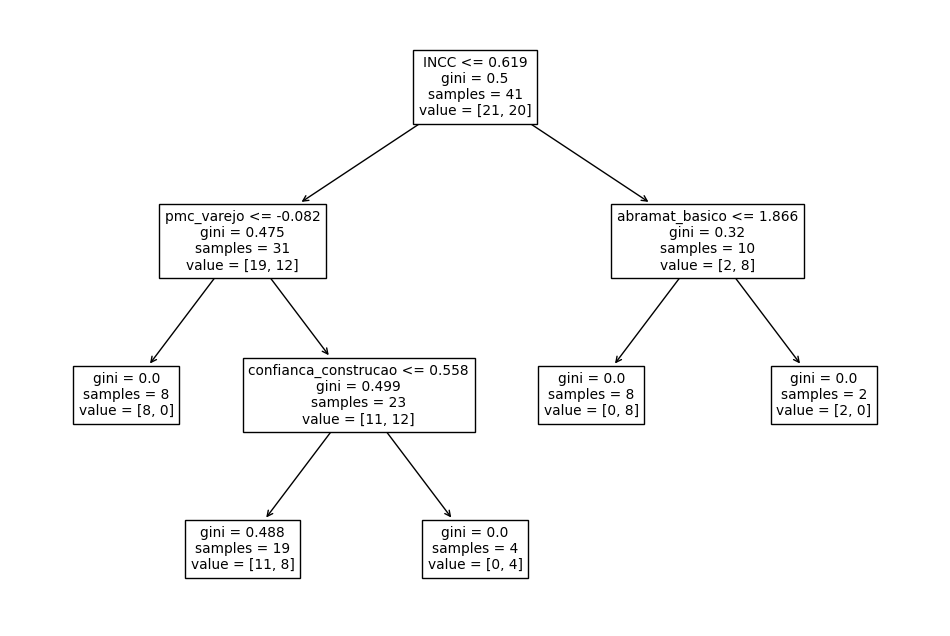

In [5]:
#fitting the models
#linear regression

from sklearn.model_selection import train_test_split
# from sklearn.linear_model import  DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
# Step 2: Split the data into training and testing sets

def train_model(df_model,model,label_row):
    scaler = StandardScaler()

    X = df_model.drop(label_row, axis=1)  # Input features
    normalized_data = scaler.fit_transform(X)
    col= df_model.drop(label_row,axis=1)

    X= pd.DataFrame(normalized_data, columns=col.columns)

    Y = df_model[label_row] 
   
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

 
 
    model.fit(X_train, Y_train)
    fig, ax = plt.subplots(figsize=(12, 8))
    tree.plot_tree(model, feature_names=df_model.columns, ax=ax)
    plt.savefig("decision_tree.png")
    predictions = model.predict(X_test)

    accuracy = accuracy_score(Y_test, predictions)

    # Print the accuracy
    print(f"Accuracy: {accuracy}")
    cm = confusion_matrix(Y_test, predictions)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

train_model(df_model_loucas_MI,DecisionTreeClassifier(max_depth=3),"MI")


## Usando o bootstrap
Como o conjunto de dados é relativamente pequeno vale a pena usar tecnicas que simulem conjuntos de dados maiores que consigam generalizar melhor a realidade e fazer o modelo ser mais representativo.

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.metrics import  precision_score,accuracy_score,recall_score,f1_score

def perform_bootstrap_classification(df, classifier, n_bootstraps=100):
    X = df.iloc[:, 1:]  
    y = df.iloc[:, 0]   

    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    bootstrap_size = len(df)
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        bootstrap_sample = resample(df, replace=True, n_samples=bootstrap_size)
        bootstrap_samples.append(bootstrap_sample)

    accuracies = []
    f1s=[]
    precisions=[]
    recalls=[]
    for bootstrap_sample in bootstrap_samples:
        X_bootstrap = bootstrap_sample.iloc[:, 1:]
        y_bootstrap = bootstrap_sample.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
   
    
    return np.mean(accuracies),np.mean(f1s),np.mean(precisions),np.mean(recalls)



## Comparando K's no KNN

O parametro K no modelo KNN é importante para determinar a eficiencia de um modelo , dessa forma , foi feito uma comparação entre o número de vizinhos utilizados e as métricas  de cada modelo.

c:\Users\samli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\samli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\samli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\samli\AppData\Local

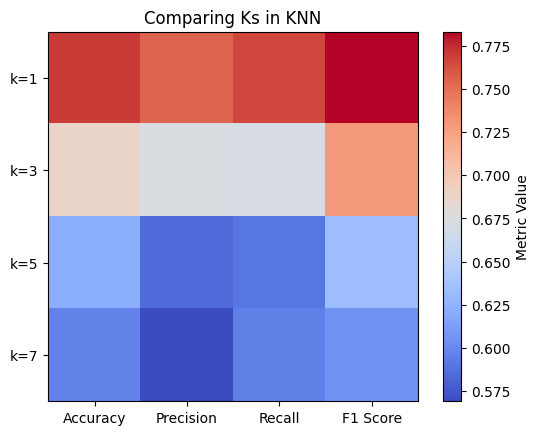

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for Model 1
model1_accuracy, model1_precision, model1_recall, model1_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, KNeighborsClassifier(1))

# Metrics for Model 2
model2_accuracy, model2_precision, model2_recall, model2_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, KNeighborsClassifier(3))

# Metrics for Model 3
model3_accuracy, model3_precision, model3_recall, model3_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, KNeighborsClassifier(5))

# Metrics for Model 4
model4_accuracy, model4_precision, model4_recall, model4_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, KNeighborsClassifier(7))
# Create a numpy array with the metrics
metrics = np.array([[model1_accuracy, model1_precision, model1_recall, model1_f1],
                    [model2_accuracy, model2_precision, model2_recall, model2_f1],
                    [model3_accuracy, model3_precision, model3_recall, model3_f1],
                    [model4_accuracy, model4_precision, model4_recall, model4_f1]])

# Define the models and metrics
models = ['k=1', 'k=3', 'k=5', 'k=7']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create the heatmap
plt.imshow(metrics, cmap='coolwarm')

# Set the tick labels
plt.xticks(np.arange(len(metric_labels)), metric_labels)
plt.yticks(np.arange(len(models)), models)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Metric Value')

# Add title
plt.title('Comparing Ks in KNN')

# Show the plot
plt.show()




## Comparando profundidade na arvorde em arvores de decisão

c:\Users\samli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\samli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\samli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


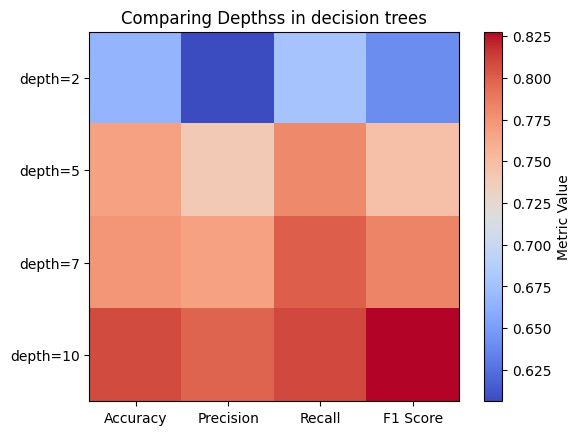

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for Model 1
model1_accuracy, model1_precision, model1_recall, model1_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, DecisionTreeClassifier(max_depth=2))

# Metrics for Model 2
model2_accuracy, model2_precision, model2_recall, model2_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, DecisionTreeClassifier(max_depth=5))

# Metrics for Model 3
model3_accuracy, model3_precision, model3_recall, model3_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, DecisionTreeClassifier(max_depth=7))

# Metrics for Model 4
model4_accuracy, model4_precision, model4_recall, model4_f1 = perform_bootstrap_classification(
    df_model_loucas_MI, DecisionTreeClassifier(max_depth=10))
# Create a numpy array with the metrics
metrics = np.array([[model1_accuracy, model1_precision, model1_recall, model1_f1],
                    [model2_accuracy, model2_precision, model2_recall, model2_f1],
                    [model3_accuracy, model3_precision, model3_recall, model3_f1],
                    [model4_accuracy, model4_precision, model4_recall, model4_f1]])

# Define the models and metrics
models = ['depth=2', 'depth=5', 'depth=7', 'depth=10']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create the heatmap
plt.imshow(metrics, cmap='coolwarm')

# Set the tick labels
plt.xticks(np.arange(len(metric_labels)), metric_labels)
plt.yticks(np.arange(len(models)), models)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Metric Value')

# Add title
plt.title('Comparing Depth in decision trees')

# Show the plot
plt.show()




## Prevendo a proporção dos mercados mensais em relação ao total anual

Além do crescimento dos faturamentos, também existem dados que representam o quanto um certo mês contribiu para o total anual do mercado. Dessa forma, é possível utilizar esses dados e tentar prever o quanto um mês contribiu de acordo com os indicadores, além de dizer quais indicadores mais contribuiram.


In [36]:
# making raw data into DFs
mercado_metais = [7.97,	8.00,	7.10,	7.04,	7.84,	7.97,	8.26,	9.15,	9.43,	9.42,	9.06,	8.75,
                  6.99,	6.94,	4.76,	4.34,	5.92,	8.55,	9.79,	10.22,	10.95,	11.63,	10.60,	9.32,
                  6.84,	7.00,	7.26,	6.97,	8.04,	8.95,	8.58,	9.54,	10.19,	9.75,	8.74,	8.16,
                  6.92,	7.70,	8.82,	7.60,	8.32,	8.69,	8.67,	9.01,	9.14,	8.65,	8.49,	7.99,
                  ]

mercado_loucas = [7.44,	7.76,	7.52,	6.86,	8.52,	7.82,	7.81,	8.76,	9.55,	9.39,	9.80,	8.76,
                  7.07,	7.00,	6.17,	4.27,	6.55,	8.27,	9.22,	9.64,	10.42,	10.91,	10.84,	9.63,
                  6.59,	6.66,	7.32,	7.48,	7.85,	8.07,	8.81,	9.00,	9.41,	10.11,	9.87,	8.83,
                  8.40,	8.64,	9.91,	8.62,	9.03,	8.73,	8.57,	8.34,	8.01,	8.16,	7.14,	6.43,
                  ]


meses = ['01-01-2019', '01-02-2019', '01-03-2019', '01-04-2019', '01-05-2019', '01-06-2019',
         '01-07-2019', '01-08-2019', '01-09-2019', '01-10-2019', '01-11-2019', '01-12-2019',
         '01-01-2020', '01-02-2020', '01-03-2020', '01-04-2020', '01-05-2020', '01-06-2020',
         '01-07-2020', '01-08-2020', '01-09-2020', '01-10-2020', '01-11-2020', '01-12-2020',
         '01-01-2021', '01-02-2021', '01-03-2021', '01-04-2021', '01-05-2021', '01-06-2021',
         '01-07-2021', '01-08-2021', '01-09-2021', '01-10-2021', '01-11-2021', '01-12-2021',
         '01-01-2022', '01-02-2022', '01-03-2022', '01-04-2022', '01-05-2022', '01-06-2022',
         '01-07-2022', '01-08-2022', '01-09-2022', '01-10-2022', '01-11-2022', '01-12-2022']


df_mercado_loucas = pd.DataFrame({'Valor': mercado_loucas, 'MÊS': meses})
df_mercado_metais = pd.DataFrame({'Valor': mercado_metais, 'MÊS': meses})
df_mercado_loucas['MÊS'] = pd.to_datetime(df_mercado_loucas['MÊS'], format='%d-%m-%Y')
df_mercado_metais['MÊS'] = pd.to_datetime(df_mercado_metais['MÊS'], format='%d-%m-%Y')
#joining all other tables

merge_list = [df_selic, df_ipca, df_incc, df_pmc_const, df_pmc_vare, df_abramat_bas,
              df_abramat_acab, df_confianca_con, df_confianca_come, df_confianca_const, df_pib_const, df_pib_ind]

df_mercado_loucas = merger(df_mercado_loucas,merge_list,"MÊS")
df_mercado_loucas.head()
df_mercado_loucas=df_mercado_loucas.drop("MÊS",axis=1)
df_mercado_metais = merger(df_mercado_metais,merge_list,"MÊS")
df_mercado_metais=df_mercado_metais.drop("MÊS",axis=1)
df_mercado_metais.head()




,Valor,SELIC,IPCA,INCC,pmc_construcao,pmc_varejo,abramat_basico,abramat_acabados,confianca_consumdior,confianca_comercio,confianca_construcao,pib_construcao,pib_industria
0,7.97,0.065,0.0032,0.0049,93.121300,97.225258,0.027,-0.017,95.3,102.3,84.5,-0.006112,-0.005361
1,8.00,0.065,0.0043,0.0009,92.874649,96.358673,0.041,0.061,94.5,99.8,84.3,-0.006112,-0.005361
2,7.10,0.065,0.0075,0.0031,95.433701,97.848053,-0.041,-0.04,90.9,98.0,82.1,-0.006112,-0.005361
3,7.04,0.065,0.0057,0.0038,98.106323,97.011742,0.008,0.003,89.7,96.3,82.5,0.008293,-0.001605
4,7.84,0.065,0.0013,0.0003,93.122620,96.671501,0.151,0.135,85.8,93.4,80.7,0.008293,-0.001605


## Executando regressões com bootstrap sobre os dados de mercado mensal
Já fizemos um classificador que consegue classificar um mês em crescimento ou decrescimento do faturamento mensal usando os indicadores de mercado. Agora, queremos fazer um regressãor usando os indicadores que consiga dar uma porcentagem do valor total do mercado do ano em relação a um mês.



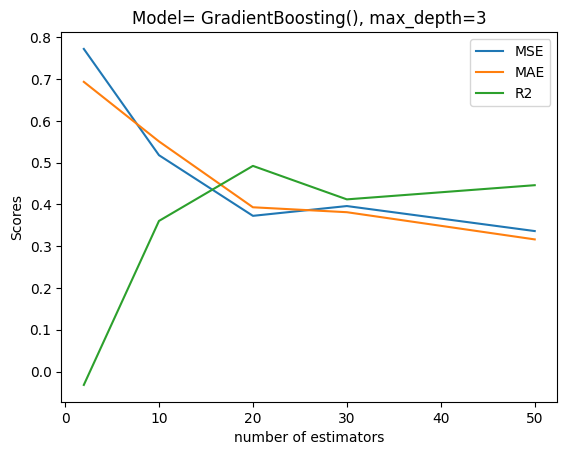

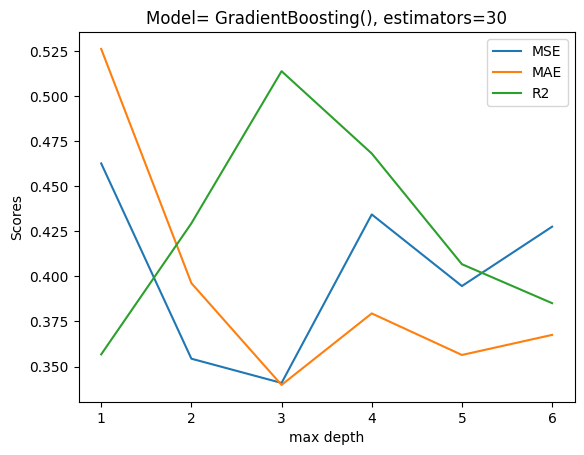

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def perform_bootstrap_regression(df, regressor, n_bootstraps=100,test_size_=0.2,return_model=False):
    X = df.iloc[:, 1:]  
    y = df.iloc[:, 0]   

    scaler = StandardScaler()
    # X_normalized = scaler.fit_transform(X)
    # Y_normalized = scaler.fit_transform(y)
    # df[:,1:] =X_normalized
    # df[:,0]=Y_normalized
    df =scaler.fit_transform(df)
    df = pd.DataFrame(df)
    bootstrap_size = len(df)
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        bootstrap_sample = resample(df, replace=True, n_samples=bootstrap_size)
        bootstrap_samples.append(bootstrap_sample)

    mse_scores = []
    mae_scores = []
    r2_scores = []
    
    for bootstrap_sample in bootstrap_samples:
        X_bootstrap = bootstrap_sample.iloc[:, 1:]
        y_bootstrap = bootstrap_sample.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=test_size_)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
    
    if return_model:
        return regressor
   
    return np.mean(mse_scores), np.mean(mae_scores), np.mean(r2_scores)

def perform_gradient_boosting_regression(df, n_estimators=100, max_depth=3, n_bootstraps=100):
    regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
    mse, mae, r2 = perform_bootstrap_regression(df, regressor, n_bootstraps=n_bootstraps)
    
    return mse, mae, r2

#comparing numbe of estimator for gradient boosting
estimators =[2,10,20,30,50]
mses=[]
maes=[]
r2s=[]

for i in estimators:
    regressor =GradientBoostingRegressor(n_estimators=i, max_depth=3)
    mse,mae,r2 = perform_bootstrap_regression(df_mercado_metais,regressor)
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)
plt.figure()
# Plotting the lines
plt.plot(estimators, mses, label='MSE')
plt.plot(estimators, maes, label='MAE')
plt.plot(estimators, r2s, label='R2')

# Adding labels and title
plt.ylabel('Scores')
plt.xlabel('number of estimators')
plt.title('Model= GradientBoosting(), max_depth=3')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

#comparing the max depth gradient boosting
depth =[1,2,3,4,5,6]
mses=[]
maes=[]
r2s=[]

for i in depth:
    regressor =GradientBoostingRegressor(n_estimators=30, max_depth=i)
    mse,mae,r2 = perform_bootstrap_regression(df_mercado_metais,regressor)
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)
plt.figure()
# Plotting the lines
plt.plot(depth, mses, label='MSE')
plt.plot(depth, maes, label='MAE')
plt.plot(depth, r2s, label='R2')

# Adding labels and title
plt.ylabel('Scores')
plt.xlabel('max depth')
plt.title('Model= GradientBoosting(), estimators=30')

# Adding a legend
plt.legend()

# Display the plot
plt.show()



In [57]:
# Comparing the results of other models

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
models = [SVR(kernel='rbf', C=1.0, epsilon=0.1), SVR(kernel='poly', C=1, epsilon=0.1),
          RandomForestRegressor(), KNeighborsRegressor(1), KNeighborsRegressor(3), LinearRegression()]
labels = ["SVR(kernel='rbf')", "SVR(kernel='poly')",
          'RandomForest', 'KNN(1)', 'KNN(3)','LinearRegression']
mses = []
maes = []
r2s = []
for i in models:

    mse, mae, r2 = perform_bootstrap_regression(df_mercado_metais, i)
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)
    print(mse, mae, r2)



0.5770360631232293 0.537499511311749 0.25858692823213325
2.0331199735087764 0.6471187674150345 -1.0118999230659596
0.3801836724814332 0.4244220400506268 0.42137142535195343
0.6234241867232831 0.390076528042645 0.2053120369127377
0.7240151505524693 0.6224222450276203 0.1331953808373612
2.1583368767369446 0.7797742849134534 -1.59127456283017


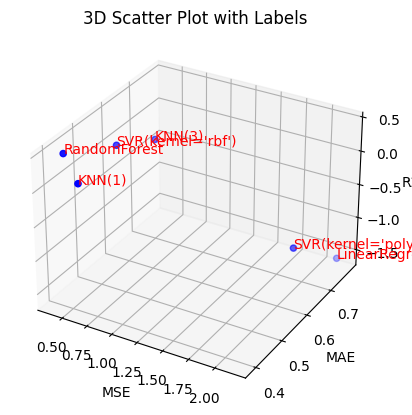

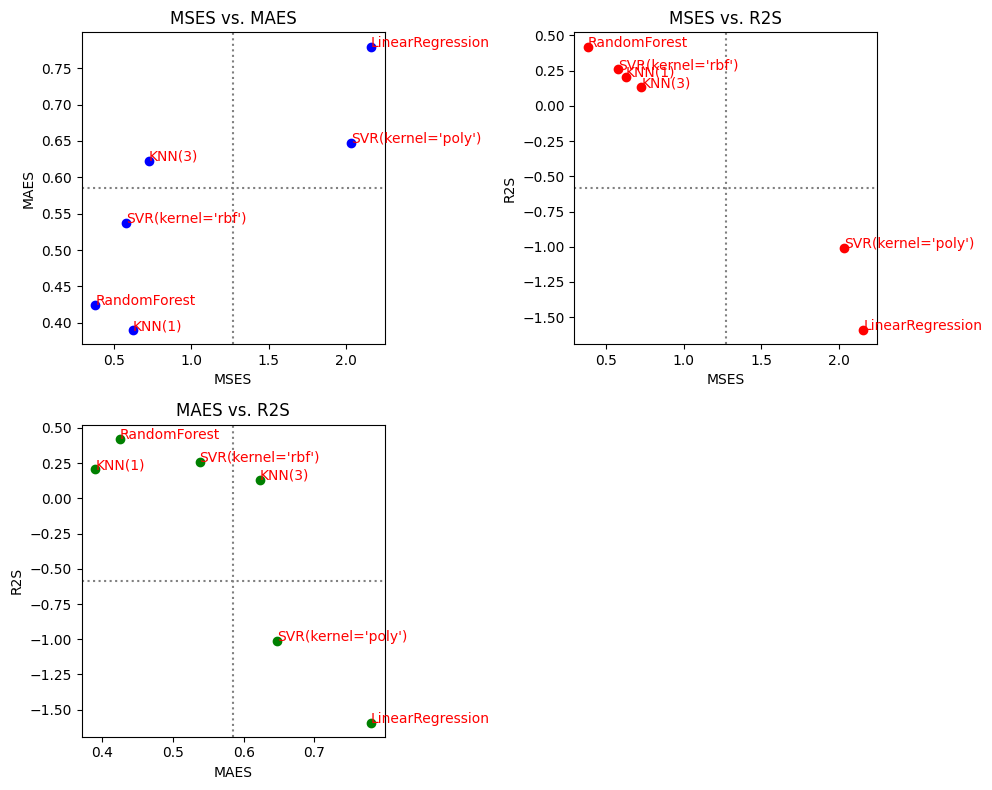

In [58]:
# Create the figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(mses, maes, r2s, c='b', marker='o')

# Add labels to each point
for i, (xi, yi, zi) in enumerate(zip(mses, maes, r2s)):
    ax.text(xi, yi, zi, str(labels[i]), color='r')

# Set labels and title
ax.set_xlabel('MSE')
ax.set_ylabel('MAE')
ax.set_zlabel('R2S')
ax.set_title('3D Scatter Plot with Labels')

# Show the plot
plt.show()
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))



mses_min = np.min(mses)
mses_max = np.max(mses)
mses_threshold = (mses_min + mses_max) / 2

maes_min = np.min(maes)
maes_max = np.max(maes)
maes_threshold = (maes_min + maes_max) / 2

r2s_min = np.min(r2s)
r2s_max = np.max(r2s)
r2s_threshold = (r2s_min + r2s_max) / 2

# Plot x vs. y

# Add dotted lines to separate the quarters
axes[0, 0].axvline(mses_threshold, linestyle='dotted', color='gray')
axes[0, 0].axhline(maes_threshold, linestyle='dotted', color='gray')

axes[0, 0].scatter(mses, maes, c='b', marker='o')
axes[0, 0].set_xlabel('MSES')
axes[0, 0].set_ylabel('MAES')
axes[0, 0].set_title('MSES vs. MAES')
for i, label in enumerate(labels):
    axes[0, 0].text(mses[i], maes[i], str(label), color='r')
 
# Plot x vs. z
axes[0, 1].axvline(mses_threshold, linestyle='dotted', color='gray')
axes[0, 1].axhline(r2s_threshold, linestyle='dotted', color='gray')

axes[0, 1].scatter(mses, r2s, c='r', marker='o')
axes[0, 1].set_xlabel('MSES')
axes[0, 1].set_ylabel('R2S')
axes[0, 1].set_title('MSES vs. R2S')
for i, label in enumerate(labels):
    axes[0, 1].text(mses[i], r2s[i], str(label), color='r')
  


# Plot y vs. z
axes[1, 0].axvline(maes_threshold, linestyle='dotted', color='gray')
axes[1, 0].axhline(r2s_threshold, linestyle='dotted', color='gray')

axes[1, 0].scatter(maes, r2s, c='g', marker='o')
axes[1, 0].set_xlabel('MAES')
axes[1, 0].set_ylabel('R2S')
axes[1, 0].set_title('MAES vs. R2S')
for i, label in enumerate(labels):
    axes[1, 0].text(maes[i], r2s[i], str(label), color='r')




# Remove the empty subplot
fig.delaxes(axes[1, 1])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### A realidade vs o Modelo de regressão
Usando todos os dados de 2018-até 2021 para treinamento, vamos prever o anos de 2022 e ver como nosso modelo se compara com a realidade.




In [66]:

df_mercado_metais_short =df_mercado_metais[:-12]
df_mercado_metais_test = df_mercado_metais[-12:]
X = df_mercado_metais_test.iloc[:, 1:]  
y = df_mercado_metais_test.iloc[:, 0]   

model = perform_bootstrap_regression(df_mercado_metais_short,RandomForestRegressor(),return_model =True)
scaler = StandardScaler()

df =scaler.fit_transform(df_mercado_metais_test)
df = pd.DataFrame(df)
X = df.iloc[:, 1:]  
# y = df.iloc[:, 0]   
output =model.predict(X)
print(output)
#unormalize data
output_2d =[[i] for i in output]
print(output_2d)
output_2d=pd.DataFrame(output_2d)
unormalized = scaler.inverse_transform(output_2d)
output_2d =[ i[0] for i in output_2d]
print(output_2d)
print(y)

[ 0.29801941  0.75740332  0.23393245  0.27246361  0.76451155  0.87277113
 -0.51423768 -0.61928163 -0.72161767 -0.71783789 -0.69640035 -0.8235024 ]
[[0.29801940976119545], [0.7574033169454615], [0.2339324493582325], [0.2724636060089577], [0.7645115537507202], [0.8727711285863586], [-0.5142376816841026], [-0.6192816255840292], [-0.7216176697486203], [-0.7178378930347133], [-0.6964003534632995], [-0.8235023972906551]]


ValueError: non-broadcastable output operand with shape (12,1) doesn't match the broadcast shape (12,13)